# CS M148 Project 2 - Binary Classification Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a **patient is suffering from heart disease** based on a host of potential medical factors.

**DEFINITIONS**

**Binary Classification:** In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

**Supervised Learning:** This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
- **age:** Age in years
- **sex:** (1 = male; 0 = female)
- **cp:** Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)
- **trestbps:** Resting blood pressure (in mm Hg on admission to the hospital)
- **cholserum:** Cholestoral in mg/dl
- **fbs** Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- **restecg:** Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))
- **thalach:** Maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeakST:** Depression induced by exercise relative to rest
- **slope:** The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)
- **ca:** Number of major vessels (0-4) colored by flourosopy
- **thal:** 1 = normal; 2 = fixed defect; 3 = reversable defect
- **sick:** Indicates the presence of Heart disease (True = Disease; False = No disease)

`sick` is the label that you will be predicting.

## Loading Essentials and Helper Functions 

In [1]:
# Here are a set of libraries we imported to complete this assignment. 
# Feel free to use these or equivalent libraries for your implementation
# If you can run this cell without any errors, you're ready to go.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 

import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from matplotlib import pyplot

import os
import itertools
import random 

%matplotlib inline

random.seed(42) 
np.random.seed(42) 

In [2]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Part 1. Load the Data and Analyze

Let's load our dataset so we can work with it (correct the path if your notebook is in a different directory than the .csv file).

In [4]:
data = pd.read_csv('heartdisease.csv')
data = data.sample(frac = 1).reset_index(drop = True)
#df = df.sample(frac=1).reset_index(drop=True)

### Question 1.1 

Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method, the describe method, and the info method to display some of the rows so we can visualize the types of data fields we'll be working with.

In [5]:
# Your code here
# You may use separate cells if you'd like (one for `head`, one for `describe`, etc.)

data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,57,1,0,150,276,0,0,112,1,0.6,1,1,1,True
1,59,1,3,170,288,0,0,159,0,0.2,1,0,3,True
2,57,1,2,150,126,1,1,173,0,0.2,2,1,3,False
3,56,0,0,134,409,0,0,150,1,1.9,1,2,3,True
4,71,0,2,110,265,1,0,130,0,0.0,2,1,2,False


In [6]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  sick      303 non-null    bool   
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


### Question 1.2
Sometimes data will be stored in different formats (e.g., string, date, boolean), but many learning methods work strictly on numeric inputs. Call the info method to determine the datafield type for each column. Are there any that are problemmatic and why?

All the columns in our dataframe are numeric (either int or float), however our target variable 'sick' is a boolean and may need to be modified. We will need to convert that feature to numeric inputs, True as 1 and False as 0. 

# Question 1.3
Determine if we're dealing with any null values. If so, report which columns.

The data does not contain any null values.

### Question 1.4
Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean `sick` variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original `sick` datafield from the dataframe.

In [8]:
data['sick'] = data['sick'].astype(int)
#data['sick'] = data['sick'].boo.replace('True',1).astype(int)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,57,1,0,150,276,0,0,112,1,0.6,1,1,1,1
1,59,1,3,170,288,0,0,159,0,0.2,1,0,3,1
2,57,1,2,150,126,1,1,173,0,0.2,2,1,3,0
3,56,0,0,134,409,0,0,150,1,1.9,1,2,3,1
4,71,0,2,110,265,1,0,130,0,0.0,2,1,2,0


### Question 1.5
Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to get a feel of how each variable performs (for example, is it a binary, or limited selection, or does it follow a gradient)? 

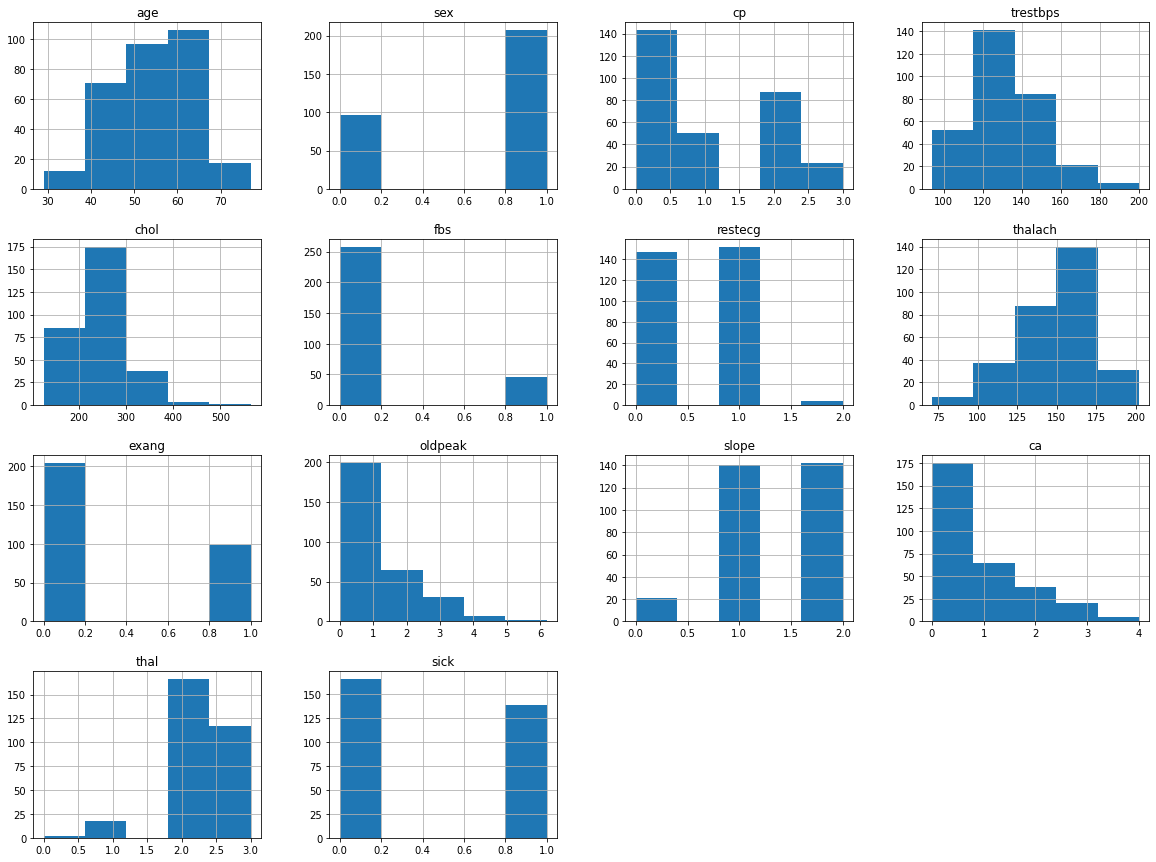

In [9]:
data.hist(bins=5, figsize=(20,15))
plt.show()


The binary variables are sex,fbs,exang and sick.

The limited selection variables are cp,restecg,slope, ca,and thal.

The gradient variables are age,trestbps,chol,oldpeak and thalach.

### Question 1.6
We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results.

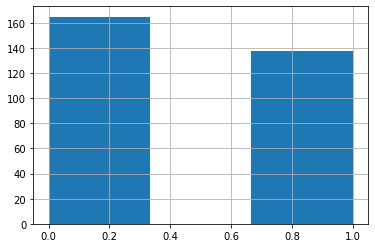

0    165
1    138
Name: sick, dtype: int64

In [10]:
# names = ['Non-sick', 'Sick']
# num = [data['sick'].value_counts()[0], data['sick'].value_counts()[1]]
# plt.bar(names,num)


data["sick"].hist(bins=3)
plt.show()
data["sick"].value_counts()

As we can see, our sample contains 165 healthy individuals and 138 sick individuals, which reflects a balanced dataset to adequately classify the two.

### Question 1.7 
Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

Artificially inflating numbers to balance a dataset may result in inaccuracy of overall databases. Concurrently showing statistically uncommon events as likely may result in more biased data happened. Artificially balancing a dataset could also change the correlation of the features.

### Question 1.8
Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations (get some domain knowledge). Intuitively, why do you think some variables correlate more highly than others? Also discuss some pairs of variables that have very little correlation and why this might be the case for them.

Hint: one possible approach you can use the `sns.heatmap()` function to map the corr() method. Note: if your heatmap is not entirely visible, [this link](https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986) may be helpful in solving the issue.

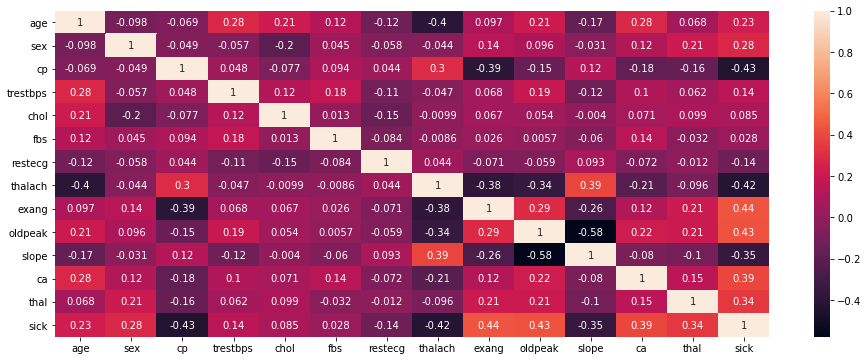

In [11]:
import seaborn as sns
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), annot=True)



[Discuss correlations here] E.g., We find the the strongest direct correlation between the presence of exercise induced angina (also a binary), and depression induced by exercise relative to rest indicates a strong direct correlation. Both of these are understandable as heart failure under conditions of duress is a clear indication of heart disease. Conversely, maximum heart rate achieved is inversely correlated, likely as a healthy heart is unable to achieve a high heart rate.

For example, slope and thalach have a positive correlation. With more the slope of the peak exercise ST segment, the more maximum heart rate achieved. 

Sick and exang have a positive correlation. If a person has exercise induced Angina, than he/she is more likely to get sick. This is reasonable since induced Angina is also an obvious symptom.

Thalach and sick have a negative correlation. If a person achieved a higher maximum heart rate, then he would possiblby more healthy. This is very reasonable since a normal heart rate level can maintain a postive life status.

Slope and oldpeak have a negative correaltion. The more upsloping of the peak exercise ST segment, the less ST depression induced by exercise relative to rest will be.

## Part 2. Prepare the Data

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

We're going to ask you to prepare 2 batches of data:
1. Raw numeric data that hasn't gone through any additional pre-processing.
2. Data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Question 2.1
Save the target column as a separate array and then drop it from the dataframe. 

In [12]:
data_y = data["sick"].copy()
data_X = data.drop("sick", axis=1)
#data_X

### Question 2.2
Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 85% of your total dataframe (hint: use the `train_test_split` method). Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.15, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (257, 13)
y_train shape: (257,)
X_test shape: (46, 13)
y_test shape: (46,)


### Question 2.3
In lecture we learned about K-Nearest Neighbor. One thing we noted was because KNN rlies on Euclidean distance, they are highly sensitive to the relative magnitude of different features. Let's see that in action! Implement a KNN algorithm on our data (use `scikit-learn`) and report the results. For this initial implementation simply use the default settings. Report on the accuracy of the resulting model.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier()
# Fit the classifier to the data
knn.fit(X_train,y_train)

y_knn_pred = knn.predict(X_test)
y_knn_pred




array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0])

In [15]:
knn.score(X_test, y_test)

0.6739130434782609

### Question 2.4 
Now implement a pipeline of your choice to transform the data. You can opt to handle null values and categoricals however you wish, however please scale your numeric features using standard scaler. Refer to Project 1 for a example pipeline that you can mimic.

In [16]:
# The binary variables are sex,fbs,exang and sick.
# The limited selection variables are cp,restecg,slope, ca,and thal.
# The gradient variables are age,trestbps,chol,oldpeak and thalach.

#we drop all the binary and limited sleection variables.

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

data_X_dropped = data_X.drop(['sex','fbs', 'exang','cp','restecg', 'slope', 'ca','thal'], axis=1)
numerical_features = list(data_X_dropped)
categorical_features = ['sex','fbs', 'exang','cp','restecg', 'slope', 'ca','thal']
full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(sparse=False), categorical_features)    
])
data_X_prep = full_pipeline.fit_transform(data_X)
data_X_prep



array([[ 0.29046364,  1.04952029,  0.57466203, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.5110413 ,  2.19177836,  0.80656782, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.29046364,  1.04952029, -2.32416031, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.61392956,  1.62064933, -0.23700823, ...,  0.        ,
         1.        ,  0.        ],
       [-0.92271345, -0.66386682,  0.05287401, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.9521966 ,  0.47839125, -0.99070203, ...,  0.        ,
         1.        ,  0.        ]])

### Question 2.5
Now split your pipelined data into an 85/15 split and run the same KNN as you did previously. Report its accuracy, and discuss the implications of the different results you are obtaining.

In [17]:
from sklearn.model_selection import train_test_split
X_pipe_train, X_pipe_test, y_pipe_train, y_pipe_test = train_test_split(data_X_prep, data_y, test_size=0.15, random_state=42)
print("X_pipe_train shape:", X_pipe_train.shape)
print("y_pipe_train shape:", y_pipe_train.shape)
print("X_pipe_test shape:", X_pipe_test.shape)
print("y_pipe_test shape:", y_pipe_test.shape)

X_pipe_train shape: (257, 30)
y_pipe_train shape: (257,)
X_pipe_test shape: (46, 30)
y_pipe_test shape: (46,)


In [18]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier()
# Fit the classifier to the data
knn.fit(X_pipe_train,y_pipe_train)

y_pipe_knn_pred = knn.predict(X_pipe_test)
knn.score(X_pipe_test, y_pipe_test)



0.8913043478260869

The difference is the shape of the X set in two data sets. The raw X_train and X_test sets have sizes of (257,13) and (46,13) respectively. The pipelined X_train and X_test sets have sizes of (257,21) and (46,30) respectively. The difference of this shape is a result of applying OneHotEncoder to the data.


The accuracy becomes higher, because I have one-hot encode categorical features and make the representation of categorical data to be more expressive.Thus the accuracy becomes higher.

### Question 2.6 Hyperparameter Optimization
As we saw in lecture, the KNN Algorithm includes an `n_neighbors` attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now letting `n` take on the values 1, 2, 3, 5, 7, 9, 10, 20, 50, 75, and 100. Run your model for each value and report the accuracy for each. Then, create a plot of accuracy versus `n_neighbors` and discuss how and why the accuracy changes as `n_neighbors` changes.

HINT: leverage Python's ability to loop to run through the array and generate results so that you don't need to manually code each iteration.

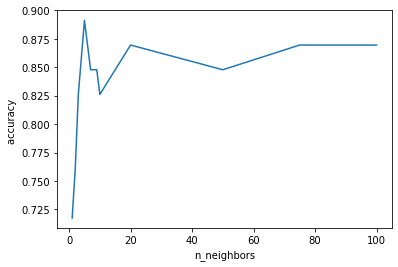

In [19]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = [1, 2, 3, 5, 7, 9, 10, 20, 50, 75, 100]
accuracy = []

for i in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_pipe_train,y_pipe_train)
    knn.predict(X_pipe_test)
    accuracy.append(knn.score(X_pipe_test, y_pipe_test))

#print(accuracy)
plt.plot(n_neighbors, accuracy)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy ')
plt.show()
    

When setting the n_neighbors parameter, if the parameter is small,the effect of noise becomes noticeable. If the parameter becomes large, some samples far away will be easily introduced, resulting in misclassification, especially when the data density distribution is not uniform.

## Part 3. Additional Learning Methods
So we have a model that seems to work well. But let's see if we can do better! To do so we'll employ multiple learning methods and compare results. Throughout this part, use the data that was produced by your pipeline earlier.

### Linear Decision Boundary Methods
We'll spend some time exploring logistic regression and SVM methods.

### Question 3.1 Logistic Regression
Let's now try a classifier, we introduced in lecture, one that's well known for handling linear models: logistic regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.  Implement a logistic regression classifier on your data with the default settings. Report accuracy, precision, recall, and F1 score and plot a confusion matrix.

Confusion matrix : 
 [[19  6]
 [ 3 18]]
Outcome values : 
 19 6 3 18
Classification report : 
               precision    recall  f1-score   support

           1       0.86      0.76      0.81        25
           0       0.75      0.86      0.80        21

    accuracy                           0.80        46
   macro avg       0.81      0.81      0.80        46
weighted avg       0.81      0.80      0.80        46



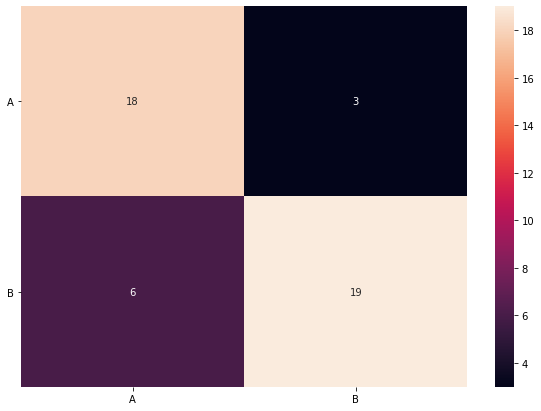

In [20]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import seaborn as sns

logisticRegr = LogisticRegression()
#solver='lbfgs', max_iter=1000
logisticRegr.fit(X_pipe_train, y_pipe_train)
y_pred = logisticRegr.predict(X_pipe_test)

# confusion matrix
matrix = confusion_matrix(y_pipe_test,y_pred, labels=[1,0])

print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_pipe_test,y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_pipe_test,y_pred,labels=[1,0])
print('Classification report : \n',matrix)

cm = confusion_matrix(y_pipe_test, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in "AB"],
                  columns = [i for i in "AB"])
plt.figure(figsize = (10,7))
heatmap2 = sns.heatmap(df_cm, annot=True)
plt.yticks(rotation = 0)
plt.show()


#draw_confusion_matrix(y_pipe_test,y_pred, [1,0])

Accuracy: 0.80
Precision: 0.86
Recall: 0.76
F1: 0.81
Confusion Matrix: 
 [[19  6]
 [ 3 18]]

### Question 3.2
Discuss what each measure (accuracy, precision, recall, and F1 score) is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.


The confusion matrix represents the amount of true positives, false positives, true negatives, and false negatives.

Accuracy measures the percentage of predicted labels that match the true labels. Accuracy is significant because it tells us how many data points were correctly labeled. This is commonly used when the important numbers are true positives and true negatives. This is a good metric for balanced distributions.We have got 0.80 accuracy which is pretty good.
Accuracy = TP+TN/TP+FP+FN+TN

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. High precision relates to the low false positive rate. We have got 0.86 precision which is pretty good.
Precision = TP/TP+FP

Recall measures tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. This is important because it tells us the ability to label all the positive values as positive. Like precision, recall is useful with imbalanced distributions. In our case, Recall score is 0.76.
Recall = TP/TP+FN

F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.81.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)


For example, the melon-field has 300 melons, 150 are good melons, 150 are bad melons. Now I predict that out of the 300 melons, 100 are good melons and 200 are bad, and out of the 100 'good melons', 80 are actual good melons and 20 are actual bad melons. And the fact that I picked 100 good melons means that I thought the remaining 200 were bad, and there were only 130 bad melons left, which means that I was right about 130+80.
My accuracy (Accuacy) = (130+80)/(130+80+20+70) =70%
My precision = 80/(80+20) = 80%
My recall = 80/ (80+70) = 53%


### Question 3.3
Graph the ROC curve of the logistic regression model.

AUC: 0.8085714285714286


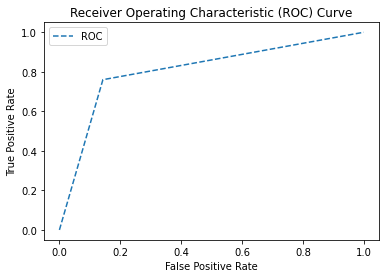

In [21]:
from sklearn.metrics import roc_curve
#metrics.plot_roc_curve(y_pred, X_test, y_test)

fpr, tpr, threshold = roc_curve(y_pipe_test, y_pred)
plt.plot(fpr, tpr, linestyle='--', label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
pyplot.legend()

auc = np.trapz(tpr,fpr)
print('AUC:', auc)

### Question 3.4
Describe what an ROC curve is and what your ROC graph output is showing.

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.
The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

In this model, AUC is 0.8988, which means that there is a 90% chance that the model will be able to distinguish between the positive and negative class.

### Question 3.5
Let's tweak a few settings. Set your solver to `newton-cg`, your `max_iter=4`, and `penalty='none'`, and rerun your model. Report out the same metrics (the 4 + confusion matrix) as before. How do your results change?

In [22]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import seaborn as sns

logisticRegr = LogisticRegression(solver='newton-cg', max_iter=4, penalty='none')
logisticRegr.fit(X_pipe_train, y_pipe_train)
y_pred = logisticRegr.predict(X_pipe_test)

# confusion matrix
matrix = confusion_matrix(y_pipe_test,y_pred, labels=[1,0])

print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_pipe_test,y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_pipe_test,y_pred,labels=[1,0])
print('Classification report : \n',matrix)


Confusion matrix : 
 [[20  5]
 [ 3 18]]
Outcome values : 
 20 5 3 18
Classification report : 
               precision    recall  f1-score   support

           1       0.87      0.80      0.83        25
           0       0.78      0.86      0.82        21

    accuracy                           0.83        46
   macro avg       0.83      0.83      0.83        46
weighted avg       0.83      0.83      0.83        46



C:\Users\ericz\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


Numbers are changed a little bit campared to the first run.

Accuracy: 0.83
Precision: 0.87
Recall: 0.80
F1: 0.83
Confusion Matrix: 
 [[20  5]
 [ 3 18]]

### Question 3.6
Did you notice that when you ran the previous model you got the following warning: `ConvergenceWarning: The max_iter was reached which means the coef_ did not converge.` Check the documentation and see if you can implement a fix for this problem, and again report your results.

Note: if you did not get a warning, which might happen to those running this notebook in VSCode, please try running the following code, as described [here](https://github.com/microsoft/vscode-jupyter/issues/1312):
```
import warnings
warnings.simplefilter(action="default")
```

In [23]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import seaborn as sns

logisticRegr = LogisticRegression(solver='newton-cg', max_iter=100, penalty='none')
logisticRegr.fit(X_pipe_train, y_pipe_train)
y_pred = logisticRegr.predict(X_pipe_test)

# confusion matrix
matrix = confusion_matrix(y_pipe_test,y_pred, labels=[1,0])

print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_pipe_test,y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_pipe_test,y_pred,labels=[1,0])
print('Classification report : \n',matrix)


Confusion matrix : 
 [[19  6]
 [ 3 18]]
Outcome values : 
 19 6 3 18
Classification report : 
               precision    recall  f1-score   support

           1       0.86      0.76      0.81        25
           0       0.75      0.86      0.80        21

    accuracy                           0.80        46
   macro avg       0.81      0.81      0.80        46
weighted avg       0.81      0.80      0.80        46



Accuracy: 0.80
Precision: 0.86
Recall: 0.76
F1: 0.81
Confusion Matrix: 
 [[19  6]
 [ 3 18]]

### Question 3.7
Explain what you changed and why this fixed the `ConvergenceWarning` problem. Are there any downsides of your fix? How might you have harmed the outcome instead? What other parameters you set may be playing a factor in affecting the results?

I changed from max_iter=4 to max_iter=100, which represents the maximum number of iterations taken for the solvers to converge.
Increasing number of iterations may help algorithm to converge. However, in this case , it does not improve the outcome. If the number of ierations is big enough, the weight of iterations are enough to fit the noise in the training data and there will be more unrepresentative features in the training samples.  

### Question 3.8
Rerun your logistic classifier, but modify the `penalty='l1'`, `solver='liblinear'` and again report the results.


In [24]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import seaborn as sns

logisticRegr = LogisticRegression(solver='liblinear', penalty='l1')
logisticRegr.fit(X_pipe_train, y_pipe_train)
y_pred = logisticRegr.predict(X_pipe_test)

# confusion matrix
matrix = confusion_matrix(y_pipe_test,y_pred, labels=[1,0])

print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_pipe_test,y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_pipe_test,y_pred,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[20  5]
 [ 2 19]]
Outcome values : 
 20 5 2 19
Classification report : 
               precision    recall  f1-score   support

           1       0.91      0.80      0.85        25
           0       0.79      0.90      0.84        21

    accuracy                           0.85        46
   macro avg       0.85      0.85      0.85        46
weighted avg       0.86      0.85      0.85        46



Accuracy: 0.85
Precision: 0.91
Recall: 0.80
F1: 0.85
Confusion Matrix: 
 [[20  5]
 [ 2 19]]

### Question 3.9
Explain what what the two solver approaches are, and why the model with `liblinear` and `l1` penalty likely produced the optimal outcome.

LIBLINEAR is a linear classifier for data with millions of instances and features. LIBLINEAR is very efficient for training large-scale problems.It supports L1-regularized classifiers. L1 regularization adds an L1 penalty equal to the absolute value of the magnitude of coefficients. In other words, it limits the size of the coefficients. L1 can yield sparse models (i.e. models with few coefficients); Some coefficients can become zero and eliminated. Lasso regression uses this method.


### Question 3.10
We also played around with different penalty terms (none, L1 etc.) Describe what the purpose of a penalty term is and the difference between L1 and L2 penalties.

The penalty parameter sets the way in which the logistic regression computes the regularization for the model. A regularization is an extra value that is added to the cost function, and its purpose is to lower the weights of the model, thus leading to a simpler model and the reduction of overfitting.A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression. The key difference between these two is the penalty term.

The main intuitive difference between the L1 and L2 regularization is that L1 regularization tries to estimate the median of the data while the L2 regularization tries to estimate the mean of the data to avoid overfitting.

L1 regularization adds an L1 penalty equal to the absolute value of the magnitude of coefficients. In other words, it limits the size of the coefficients. L1 can yield sparse models (i.e. models with few coefficients); Some coefficients can become zero and eliminated. Lasso regression uses this method.
L2 regularization adds an L2 penalty equal to the square of the magnitude of coefficients. L2 will not yield sparse models and all coefficients are shrunk by the same factor (none are eliminated). Ridge regression and SVMs use this method.


### Question 3.11 Support Vector Machine (SVM)

A support vector machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In 2-D space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

Implement an SVM classifier on your pipelined data (recommend using `scikit-learn`) For this implementation you can simply use the default settings, but set `probability=True`.

In [25]:
from sklearn import svm

clf_raw = svm.SVC(probability = True)
clf_raw.fit(X_pipe_train,y_pipe_train)

y_pred_svm = clf_raw.predict(X_pipe_test)


### Question 3.12 
Report the accuracy, precision, recall, F1 Score, and confusion matrix of the resulting model.

In [26]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# confusion matrix
matrix = confusion_matrix(y_pipe_test,y_pred_svm, labels=[1,0])

print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_pipe_test,y_pred_svm,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_pipe_test,y_pred_svm,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[20  5]
 [ 3 18]]
Outcome values : 
 20 5 3 18
Classification report : 
               precision    recall  f1-score   support

           1       0.87      0.80      0.83        25
           0       0.78      0.86      0.82        21

    accuracy                           0.83        46
   macro avg       0.83      0.83      0.83        46
weighted avg       0.83      0.83      0.83        46



Accuracy: 0.83
Precision: 0.87
Recall: 0.80
F1: 0.83
Confusion Matrix: 
 [[20  5]
 [ 3 18]]

### Question 3.13
Rerun your SVM, but now modify your model parameter kernel to be `linear`. Again report your accuracy, precision, recall, F1 scores, and confusion matrix and plot the new ROC curve.  

Confusion matrix : 
 [[20  5]
 [ 4 17]]
Outcome values : 
 20 5 4 17
Classification report : 
               precision    recall  f1-score   support

           1       0.83      0.80      0.82        25
           0       0.77      0.81      0.79        21

    accuracy                           0.80        46
   macro avg       0.80      0.80      0.80        46
weighted avg       0.81      0.80      0.80        46

AUC: 0.8047619047619048


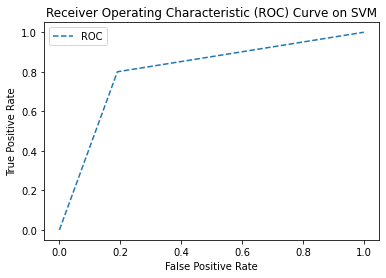

In [27]:
from sklearn.metrics import roc_curve

svm_linear_clf = svm.SVC(probability = True, kernel='linear')
svm_linear_clf.fit(X_pipe_train,y_pipe_train)
y_linear_pred_svm = svm_linear_clf.predict(X_pipe_test)

# confusion matrix
matrix = confusion_matrix(y_test,y_linear_pred_svm, labels=[1,0])

print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_pipe_test,y_linear_pred_svm,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_pipe_test,y_linear_pred_svm,labels=[1,0])
print('Classification report : \n',matrix)

fpr_svm, tpr_svm, threshold = roc_curve(y_pipe_test, y_linear_pred_svm)
plt.plot(fpr_svm, tpr_svm, linestyle='--', label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on SVM')
plt.legend()

auc_svm = np.trapz(tpr_svm,fpr_svm)
print('AUC:', auc_svm)


Accuracy: 0.80
Precision: 0.83
Recall: 0.80
F1: 0.82
Confusion Matrix: 
 [[20  5]
 [ 4 17]]

### Question 3.14
Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

The accuracy stays the same. The recall and f1 go down and the precision goes up for the linear kernel model. The numbers do not change dramatically and the graphs still show some similarity. The linear kernel is used when the data is linearly separable. The linear kernel is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data. The performance of the model decreased because the dataset we used is not linearly separable.

### Question 3.15
Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. How do they differ in how they try to find this boundary?


Logistic regression is an algorithm that is used in solving classification problems. It is a predictive analysis that describes data and explains the relationship between variables. Logistic regression is applied to an input variable (X) where the output variable (y) is a discrete value which ranges between 1 (yes) and 0 (no). Logistic Regression finds the decision boundary by finding a set of weights and minimizing the cost. Once the weights are found, they can be generalized to the hyperplane/decision boundary.

The support vector machine is a model used for both classification and regression problems though it is mostly used to solve classification problems. The algorithm creates a hyperplane or line(decision boundary) which separates data into classes. It uses the kernel trick to find the best line separator (decision boundary that has same distance from the boundary point of both classes). It is a clear and more powerful way of learning complex non linear functions.


### Question 3.16
We also learned about linear regression in class. Why is linear regression not a suitable model for this classification task?

There are some differences between linear regression and logistic regression. 

The output of linear regression is continuous and takes arbitrary values in finite space; The output of the logistic regression is expected to be discrete with a finite number of values. The expectation of linear regression is continuous variables, while the logistic regression is expected to be discrete categories. 

In this case, we are epxecting the outcome (dependent variable) to be only a limited number of possible values, which is sick or not sick. So we should use logistic regression.


### Statistical Classification Methods
Now we'll explore a statistical classification method, the naive Bayes classifier.

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes' theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable. Bayes' theorem states the following relationship, given class variable $C_k$ and dependent feature vector $\bold{x} = [x_1, x_2, ..., x_n]^T$, $$P(C_k | \bold{x}) = \frac{P(C_k)P(\bold{x} | C_k)}{P(\bold{x})}$$

Note for our purposes, there are 2 possible classes (sick or not sick), so $k$ ranges from 1 to 2.

### Question 3.17
Implement a naive Bayes Classifier on the pipelined data. Use the `GaussianNB` model. For this model, simply use the default parameters. Report out the number of mislabeled points that result (i.e., both the false positives and false negatives), along with the accuracy, precision, recall, F1 Score and confusion matrix. Also, plot an ROC curve.

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

gnb = GaussianNB()
#Train the model using the training sets
gnb.fit(X_pipe_train, y_pipe_train)
#Predict the response for test dataset
y_gnb_pred = gnb.predict(X_pipe_test)
y_gnb_pred

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1])

Confusion matrix : 
 [[21  4]
 [10 11]]
Outcome values : 
 21 4 10 11
Classification report : 
               precision    recall  f1-score   support

           1       0.68      0.84      0.75        25
           0       0.73      0.52      0.61        21

    accuracy                           0.70        46
   macro avg       0.71      0.68      0.68        46
weighted avg       0.70      0.70      0.69        46

AUC: 0.6819047619047619


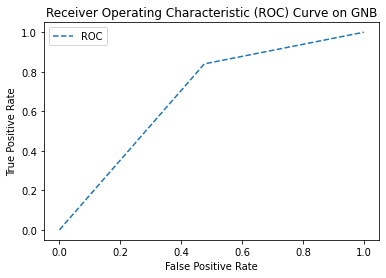

In [29]:

# confusion matrix
matrix = confusion_matrix(y_test,y_gnb_pred, labels=[1,0])

print('Confusion matrix : \n',matrix)

tp, fn, fp, tn = confusion_matrix(y_pipe_test,y_gnb_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

matrix = classification_report(y_pipe_test,y_gnb_pred,labels=[1,0])
print('Classification report : \n',matrix)


fpr_gnb, tpr_gnb, threshold = roc_curve(y_pipe_test, y_gnb_pred)
plt.plot(fpr_gnb, tpr_gnb, linestyle='--', label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on GNB')
plt.legend()

auc_gnb = np.trapz(tpr_gnb,fpr_gnb)
print('AUC:', auc_gnb)

### Question 3.18
Discuss the observed results. What assumptions about our data are we making here and why might those be inaccurate?

The accuracy goes down dramatically. The recall, f1 and precision all go down dramatically. There are so many false postive cases in this prediction which make the whole accuracy inaccurate.

Naive Bayes is known to be a 'bad' estimator,because it assumes the features are independent, the probabilities are incorrect if this assumption is not correct. Thus, the decision boundary is constrained for GaussianNB to learn because of "naive" assumption of the data. 

## Part 4: Cross Validation and Model Selection
You've sampled a number of different classification techniques, leveraging nearest neighbors, linear classifiers, and statistical classifiers. You've also tweaked with a few parameters for those models to optimize performance. Based on these experiments you should have settled on a particular model that performs most optimally on this dataset. Before our work is done though, we want to ensure that our results are not the result of the random sampling of our data we did with the train-test split. To check this, we will conduct a K-fold cross validation of our top 2 performing models, assess their cumulative performance across folds (report accuracy, precision, recall, and F1 score), and determine the best model for our particular data.

### Question 4.1
Select your top 2 performing models and run a 10-Fold cross validation on both. Report your best performing model.


In [34]:
#Logistic Regression Model solver='liblinear', penalty='l1'

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

new_y = data['sick']
kfold = KFold(n_splits=10, random_state=42, shuffle=True) 

model1 = LogisticRegression(solver='liblinear', penalty='l1')
scores1 = cross_val_score(model1, data_X_prep, new_y, cv=kfold)
y_pred = cross_val_predict(model1, data_X_prep, new_y, cv=kfold)


print('Cross Validation accuracy scores for Logistic Regression: %s' % scores1)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores1),np.std(scores1)))

Cross Validation accuracy scores for Logistic Regression: [0.77419355 0.87096774 0.87096774 0.9        0.93333333 0.76666667
 0.83333333 0.86666667 0.9        0.8       ]
Cross Validation accuracy: 0.852 +/- 0.053


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier



print('Finding the best k...')
k = 1
value = dict()
k_error_plot = dict()

while k < 50:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True) 
    knn = KNeighborsClassifier(n_neighbors=k)
    #estimator = knn.set_params()
    scores = cross_val_score(knn, X, y, cv=kfold)
    y_pred = cross_val_predict(knn, X, y, cv=kfold)
    mean = (np.mean(scores))
    value[cv] = mean
    k += 2
    
print(scores)
print(value)
    




Confusion matrix : 
 [[112  26]
 [ 19 146]]
Outcome values : 
 112 26 19 146
Classification report : 
               precision    recall  f1-score   support

           1       0.85      0.81      0.83       138
           0       0.85      0.88      0.87       165

    accuracy                           0.85       303
   macro avg       0.85      0.85      0.85       303
weighted avg       0.85      0.85      0.85       303



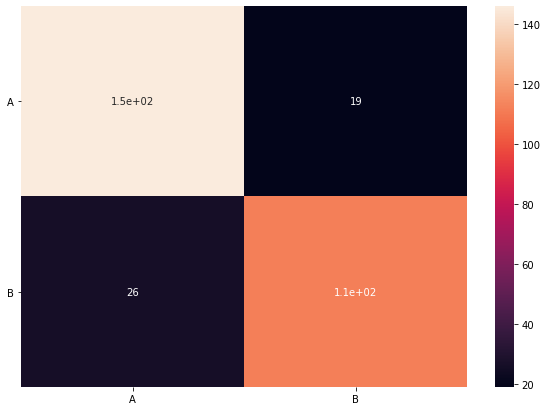

In [35]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import seaborn as sns



# confusion matrix
matrix = confusion_matrix(new_y,y_pred, labels=[1,0])

print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(new_y,y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(new_y,y_pred,labels=[1,0])
print('Classification report : \n',matrix)

cm = confusion_matrix(new_y, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in "AB"],
                  columns = [i for i in "AB"])
plt.figure(figsize = (10,7))
heatmap2 = sns.heatmap(df_cm, annot=True)
plt.yticks(rotation = 0)
plt.show()



In [32]:
#SVM with kernel = linear

from sklearn import svm

model2 = svm.SVC(probability = True, kernel='linear')
scores2 = cross_val_score(model2, data_X_prep, new_y, cv=kfold)
y_pred = cross_val_predict(model2, data_X_prep, new_y, cv=kfold)
 
print('Cross Validation accuracy scores for SVM: %s' % scores2)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

Cross Validation accuracy scores for SVM: [0.80645161 0.83870968 0.80645161 0.86666667 0.86666667 0.73333333
 0.83333333 0.86666667 0.86666667 0.8       ]
Cross Validation accuracy: 0.828 +/- 0.041


Confusion matrix : 
 [[109  29]
 [ 23 142]]
Outcome values : 
 109 29 23 142
Classification report : 
               precision    recall  f1-score   support

           1       0.83      0.79      0.81       138
           0       0.83      0.86      0.85       165

    accuracy                           0.83       303
   macro avg       0.83      0.83      0.83       303
weighted avg       0.83      0.83      0.83       303



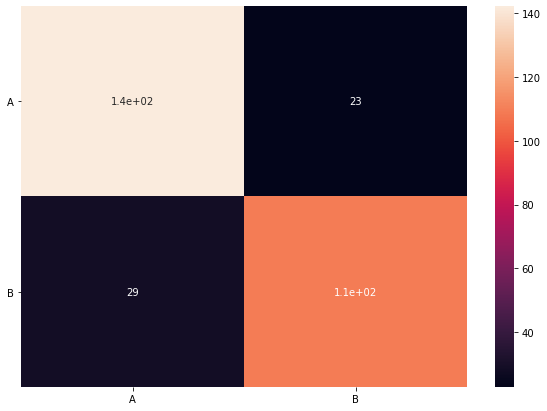

In [33]:
from sklearn import svm
import seaborn as sns




# confusion matrix
matrix = confusion_matrix(new_y,y_pred, labels=[1,0])

print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(new_y,y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(new_y,y_pred,labels=[1,0])
print('Classification report : \n',matrix)

cm = confusion_matrix(new_y, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in "AB"],
                  columns = [i for i in "AB"])
plt.figure(figsize = (10,7))
heatmap2 = sns.heatmap(df_cm, annot=True)
plt.yticks(rotation = 0)
plt.show()


With the two models I choose, Logistic Regression Model (with parameter solver='liblinear', penalty='l1') has a better performing.

### Question 4.2
Discuss your results and why they differ slightly from what you got for the 2 models above.

The purpose of cross-validation is model checking, not model building. K-fold cross validation is a way to test how well your model is able to get trained by some data and then predict data it hasn't seen. We can use cross-validation to select the better performing model, then we train that model on all the data. We don't use the actual model instances we trained during cross-validation for our final predictive model.
Therefore, the result cannot directly refelect the accuracy of a particular with that particular model, thus generate differences.




### Question 4.3
Out of these 2 models, based on their scores for the 4 metrics, which one would you pick for this specific case of predicting if someone has heart disease or not?

Sicne it is a Classification problem, I would choose Logistic Regression model. By doing confusion matrices,  and comparing accuracy, precision, recall, F1, auc and 10-Fold cross validation on both models, I believe that Logistic Regression model can achieve a higher accuracy.